In [61]:
import gym
import copy
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import numpy as np

import time
env = gym.envs.make("CartPole-v1")


In [62]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [63]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

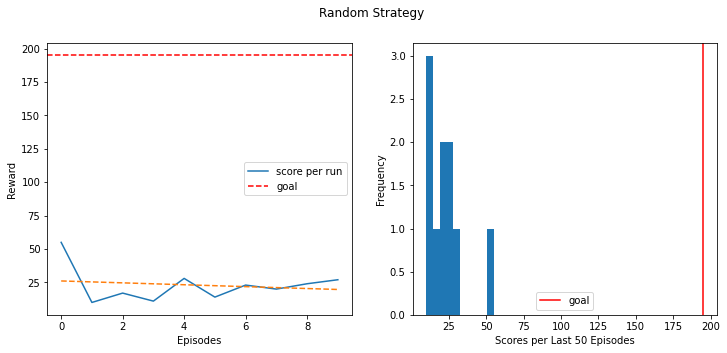

In [64]:
random_s = random_search(env, 10)


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop,Adam

In [66]:
from tensorflow.keras.initializers import RandomUniform
import tensorflow

In [67]:
state=env.reset()
state.shape

(4,)

In [82]:
def q_learning(env,model ,episodes, gamma=0.9, 
               epsilon=1, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True,hidden_dim=64,state_dim=4,action_dim=2):
    """Deep Q Learning algorithm using the DQN. """

    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1

        # Reset state
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Implement greedy search policy to explore the state space
            q_values = model.predict(state.reshape(1,state_dim),batch_size=1)
            print(epsilon)

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_values[0])
                #print(action)
            # Take action and add reward to total
            next_state, reward, done, _= env.step(action)
            newQ=model.predict(next_state.reshape(1,state_dim), batch_size=1)
            #print(newQ)
            maxQ = np.max(newQ)
            #print(maxQ)
            y = np.zeros((1,action_dim))
            y[:] = q_values[:]
            if done:
                update=reward
            else:
                update = (reward + (gamma * maxQ))
            y[0][action] = update
            # print(action)
            # print(y)
            # print(model.layers[4].get_weights())  
            # print("--------------------------------------------------------------------")         
            model.fit(state.reshape(1,state_dim), y, batch_size=1, epochs=1, verbose=1)
            #print(model.layers[0].get_weights())

            state=next_state


            # Update total and memory
            total += reward             


        # Update epsilon
        epsilon = max(epsilon/episode_i, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

In [83]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 50
# Number of hidden nodes in the DQN
n_hidden = 64

In [84]:
model=Sequential()
initializer =RandomUniform(minval=0.)
model.add(tensorflow.keras.layers.InputLayer(input_shape=(n_state,)))
model.add(Dense(n_hidden, kernel_initializer=initializer))
model.add(Activation('relu'))
model.add(Dense(n_hidden*2,kernel_initializer=initializer))
model.add(Activation('relu'))
model.add(Dense(n_action,kernel_initializer=initializer))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))   

In [85]:
model.layers

In [86]:

simple = q_learning(env,model, episodes, gamma=.9, epsilon=1,state_dim=n_state, action_dim=2, hidden_dim=n_hidden)

KeyboardInterrupt: 